In [171]:
# The sys.stdout statements is to resolve proplems with printing statements in jupyter notebook, 
# when removed progress updates printed are not shown in the notebookr
import sys
stdout = sys.stdout

from ms2query.ms2library import MS2Library
sys.stdout = stdout
from ms2query.utils import load_pickled_file

tanimoto_scores_df_file = "../../data/files_for_performance_analysis/ALL_GNPS_210409_positive_tanimoto_scores.pickle"
sqlite_file =  "../../data/models_embeddings_files/ALL_GNPS_210409_train_split.sqlite"

# Load in results of selecting best matches for the test spectra
results_test_spectra_file = "../../data/files_for_performance_analysis/results_with_match_all_scores_test_spectra_dropout_reg.pickle"
results = load_pickled_file(results_test_spectra_file)

# Test spectra
test_spectra = load_pickled_file("../../data/files_for_performance_analysis/ALL_GNPS_210409_test_split.pickle")
# Only select first 2250 spectra belonging to 250 inchikeys not stored in library
test_spectra_without_match = test_spectra[:2250]

In [172]:
from ms2query.query_from_sqlite_database import get_metadata_from_sqlite

def select_best_match_and_seperate_mass(
    result_matches, tanimoto_scores_file, query_spectra, sqlite_file_location, select_on_MS2Query = True):
    """Returns a list with all the ms2query scores and tanimoto scores for the best matches"""
    
    tanimoto_scores = load_pickled_file(tanimoto_scores_file)
    ms2query_scores_and_tanimoto = []
    
    for query_spectrum in query_spectra:
        query_spectrum_id = query_spectrum.get("spectrumid")
        query_spectrum_inchikey = query_spectrum.get("inchikey")[:14]
        
        if select_on_MS2Query:
            best_match = result_matches[query_spectrum_id].iloc[0]
            best_match_spectrum_id = best_match.name
            best_match_score = best_match.loc["ms2query_model_prediction"]

        else:
            # Selection on highest MS2Deepscore
            best_match_spectrum_id = result_matches[query_spectrum_id]["ms2ds_score"].idxmax()
            best_match_score = result_matches[query_spectrum_id]["ms2ds_score"].max()

        best_match_inchikey = get_metadata_from_sqlite(
            sqlite_file_location, [best_match_spectrum_id], "spectrumid")[best_match_spectrum_id]["inchikey"][:14]
        tanimoto_score = tanimoto_scores.loc[best_match_inchikey, query_spectrum_inchikey]
        
        ms2query_scores_and_tanimoto.append((best_match_score, tanimoto_score, query_spectrum.get("parent_mass")))
    return ms2query_scores_and_tanimoto

In [173]:
# Calculate tanimoto scores of found matches based on MS2Query
ms2query_and_tanimoto = select_best_match_and_calculate_tanimoto_score(
    results, tanimoto_scores_df_file, test_spectra_without_match, sqlite_file)
# Calculate tanimoto scores of found matches based on MS2Deepscore
ms2ds_and_tanimoto = select_best_match_and_calculate_tanimoto_score(
    results, tanimoto_scores_df_file, test_spectra_without_match, sqlite_file, False)
print(ms2query_and_tanimoto)
print(ms2ds_and_tanimoto)

[(0.3912608325481415, 0.25766871165644173, 355.021724), (0.6229788661003113, 0.1337579617834395, 122.992724), (0.3478207588195801, 0.04477611940298507, 122.992724), (0.41389361023902893, 0.15614617940199335, 268.124724), (0.2757940888404846, 0.1201923076923077, 268.124724), (0.36814558506011963, 0.06429780033840947, 268.124724), (0.2785327732563019, 0.06890756302521009, 268.124724), (0.48242342472076416, 0.571830985915493, 209.127724), (0.7835975885391235, 0.571830985915493, 209.127724), (0.7439401745796204, 0.571830985915493, 209.127724), (0.450568825006485, 0.16583416583416583, 418.255724), (0.42965495586395264, 0.18786464410735124, 418.255724), (0.3203134536743164, 0.1921182266009852, 418.255724), (0.5370057821273804, 0.1850613154960981, 209.127724), (0.4459436535835266, 0.6978998384491115, 209.12572400000002), (0.5595837831497192, 0.6978998384491115, 209.127724), (0.6325550079345703, 0.5321756894790602, 444.199782), (0.7331511974334717, 0.5321756894790602, 444.199782), (0.606195747

In [175]:
from matplotlib import pyplot as plt
import numpy as np

def plot_tanimoto_score_distr_masses(scores_and_tanimoto, cut_off_ms2q, mass_bins):
    bins = np.linspace(0, 1, 11)
    ms2q_scores_list = []
    label_list = []
    weight_list = []
    for i in range(len(mass_bins)-1):
        min_mass = mass_bins[i]
        max_mass = mass_bins[i+1]
        
        ms2query_and_tanimoto_mass_range = [scores for scores in scores_and_tanimoto if scores[2] > min_mass and scores[2] < max_mass]

        # Select scores for ms2query
        selected_scores_ms2q = [scores[1] for scores in ms2query_and_tanimoto_mass_range if scores[0] > cut_off_ms2q]
        ms2q_percentage_selected = len(selected_scores_ms2q)/len(ms2query_and_tanimoto_mass_range)*100
        print("mass range ",min_mass, "-", max_mass)
        print(len(ms2query_and_tanimoto_mass_range))
        print(ms2q_percentage_selected)
        weight_to_convert_to_percentage = 100/len(ms2query_and_tanimoto_mass_range)
        weights_ms2q = [weight_to_convert_to_percentage] * len(selected_scores_ms2q)
        ms2q_scores_list.append(selected_scores_ms2q)
        label_list.append(str(min_mass) + "-" + str(max_mass) + " Da, Recall: " + str(int(ms2q_percentage_selected)) + "%")
        weight_list.append(weights_ms2q)
#     print(ms2q_scores_list)
#     print(label_list)
    
    
    plt.hist(ms2q_scores_list, bins, label = label_list, weights = weight_list, stacked=False, rwidth = 0.9)

    plt.legend(loc = "upper center", title = "Mass range:")

    plt.xlabel("tanimoto_score")
    plt.ylabel("Percentage of spectra (per bin)")
    plt.ylim(0, 50)

    plt.show

mass range  0 - 300
690
100.0
mass range  300 - 600
984
100.0
mass range  600 - 2000
576
100.0


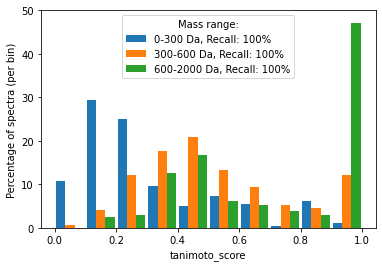

In [179]:
# plot_tanimoto_score_distr_masses(ms2query_and_tanimoto, 0, [0,100,200,300,400,500,600,700,800,900,1000,5000])
# plot_tanimoto_score_distr_masses(ms2query_and_tanimoto, 0.8, [600,5000])
plot_tanimoto_score_distr_masses(ms2query_and_tanimoto, 0, [0,300, 600, 2000])


mass range  0 - 300
690
23.333333333333332
mass range  300 - 600
984
28.760162601626014
mass range  600 - 2000
576
60.59027777777778


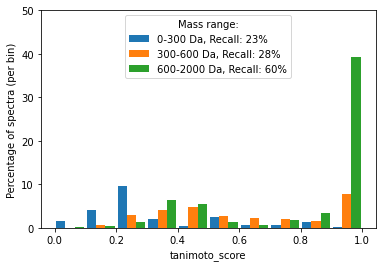

In [180]:
plot_tanimoto_score_distr_masses(ms2ds_and_tanimoto, 0.958, [0,300, 600, 2000])

In [76]:
from matplotlib import pyplot as plt
import numpy as np

def plot_tanimoto_score_distr_masses(ms2query_scores_and_tanimoto, cut_off_ms2q, mass_bins):
    bins = np.linspace(0, 1, 11)
    ms2q_scores_list = []
    label_list = []
    for i in range(len(mass_bins)-1):
        min_mass = mass_bins[i]
        max_mass = mass_bins[i+1]
        
        ms2query_and_tanimoto_mass_range = [scores for scores in ms2query_and_tanimoto if scores[2] > min_mass and scores[2] < max_mass]

        # Select scores for ms2query
        selected_scores_ms2q = [scores[1] for scores in ms2query_and_tanimoto_mass_range if scores[0] > cut_off_ms2q]
        ms2q_percentage_selected = len(selected_scores_ms2q)/len(ms2query_and_tanimoto_mass_range)*100
        print("mass range ",min_mass, "-", max_mass)
        print(len(ms2query_and_tanimoto_mass_range))
        print(ms2q_percentage_selected)
        weight_to_convert_to_percentage = 100/len(ms2query_and_tanimoto_mass_range)
        weights_ms2q = [weight_to_convert_to_percentage] * len(selected_scores_ms2q)
        ms2q_scores_list.append(selected_scores_ms2q)
        label_list.append(str(min_mass) + "-" + str(max_mass))
#     print(ms2q_scores_list)
#     print(label_list)
    
    
    plt.bar(ms2q_scores_list, bins, label = label_list, stacked=False, rwidth = 0.9)

    plt.legend(loc = "upper center", title = "Select on:")
    plt.xlabel("tanimoto_score")
    plt.ylabel("Nr of spectra")
#     plt.ylim(0, 70)

    plt.show

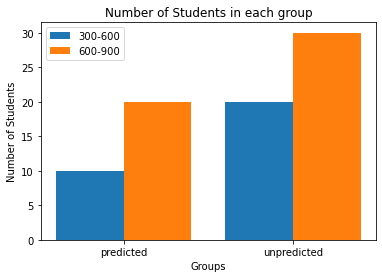

In [92]:
X = ["predicted", "unpredicted"]
Ygirls = [10,20]
Zboys = [20,30]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Ygirls, 0.4, label = '300-600')
plt.bar(X_axis + 0.2, Zboys, 0.4, label = '600-900')
  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Number of Students")
plt.title("Number of Students in each group")
plt.legend()
plt.show()

2250
87
87
36.7816091954023
9.195402298850574


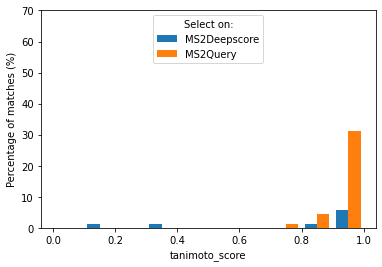

In [30]:

compare_tanimoto_score_distribution(ms2query_and_tanimoto_mass_range, ms2ds_and_tanimoto_mass_range, 0.795, 0.9812) # 20%

# print(len(ms2query_and_tanimoto))
# max_mass = 1000
# min_mass = 800
# ms2query_and_tanimoto_mass_range = [scores for scores in ms2query_and_tanimoto if scores[2] > min_mass and scores[2] < max_mass]
# ms2ds_and_tanimoto_mass_range = [scores for scores in ms2ds_and_tanimoto if scores[2] > min_mass and scores[2] < max_mass]
# print(len(ms2query_and_tanimoto_mass_range))
# print(len(ms2ds_and_tanimoto_mass_range))

# compare_tanimoto_score_distribution(ms2query_and_tanimoto_mass_range, ms2ds_and_tanimoto_mass_range, 0.795, 0.9812) # 20%

In [7]:
print(ms2ds_and_tanimoto)

[(0.8063500703381243, 0.2815734989648033, 355.021724), (0.9734906496373837, 0.11610486891385768, 122.992724), (0.8828240388309155, 0.05860805860805861, 122.992724), (0.8403437557013925, 0.18887015177065766, 268.124724), (0.8319304963605603, 0.30318257956448913, 268.124724), (0.7973954405212021, 0.11611374407582939, 268.124724), (0.8307899747656704, 0.30318257956448913, 268.124724), (0.8645607130703601, 0.15805022156573117, 209.127724), (0.8638568356878826, 0.2402123424021234, 209.127724), (0.8971566237329158, 0.16904761904761906, 209.127724), (0.9491538155163429, 0.1850613154960981, 418.255724), (0.9388063451657161, 0.1850613154960981, 418.255724), (0.883495706577661, 0.571830985915493, 418.255724), (0.8898544274744287, 0.6978998384491115, 209.127724), (0.9040430215694102, 0.07987220447284345, 209.12572400000002), (0.9126590209152414, 0.6978998384491115, 209.127724), (0.9152715262016844, 0.5085836909871244, 444.199782), (0.9479603777443587, 0.4760076775431862, 444.199782), (0.939317959